In [ ]:
library(astsa)
library(forecast)
library(FitAR)
library(Metrics)

df <- read.csv("projectdata_covid.csv")
head(df)

# 1 Executive Summary
The COVID-19 pandemic, caused by SARS-CoV-2, presents an unprecedented and global healthcare challenge. Forecast models for new cases are essential to develop effective healthcare plans for mitigating the spread of the virus. In this report, we model the emergence of COVID-19 cases in Gotham City from 6/20/2020 to 8/18/2020 and predict values for 8/19/2020 to 8/28/2020. From our parametric model with SARMA(0,1)[14] noise, new cases of COVID-19 will continue to increase over the next ten days, reaching a historical high of ~1700 cases on 8/24/2020. 

# 2 Exploratory Data Analysis

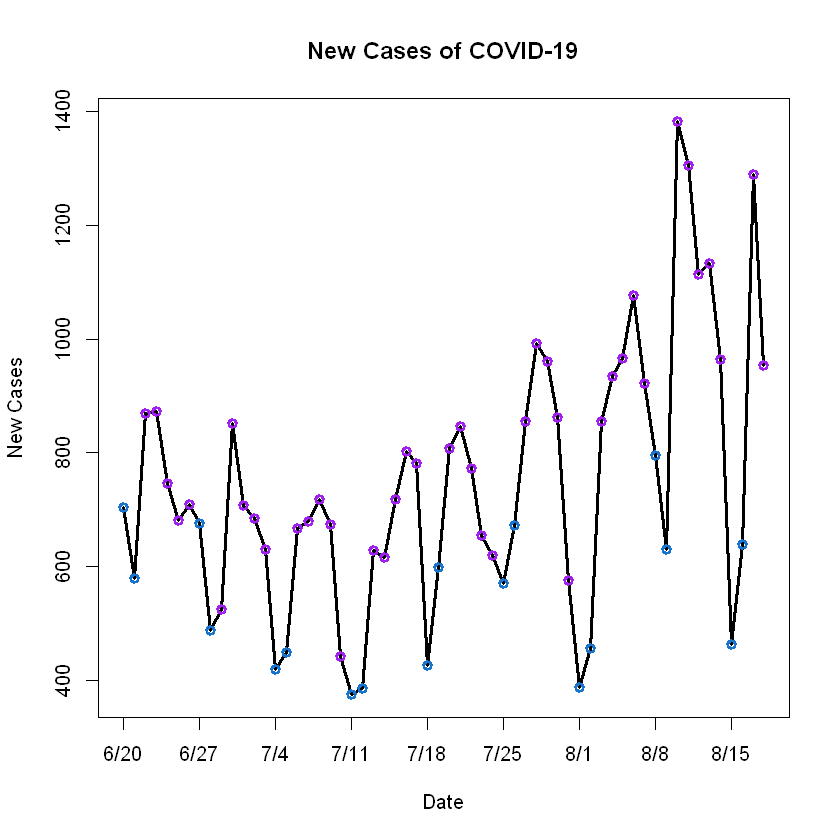

In [24]:
# plot new cases
plot.ts(df$New.Cases, type = "o", lwd = 2.5, 
        xaxt = "n", xlab = "Date", ylab = "New Cases", main = "New Cases of COVID-19")
time <- c(1:length(df$New.Cases))

#Day of week and month of year values
df$DoW <- weekdays(as.Date(df$Date, tryFormats = "%m/%d/%Y")) # weekdays() extracts the DoW from a Date value
df$MoY <- months(as.Date(df$Date, tryFormats = "%m/%d/%Y")) # months() extracts MoY from a Date value

#labels for the xaxis
xLabel <- c("6/20", "6/27", "7/4", "7/11", "7/18", "7/25", "8/1", "8/8", "8/15") 
axis(side = 1, at = seq(1,60, by = 7), labels = xLabel) # replace numerical labels with date labels

#color weekday values purple and weekend values blue
points(which(df$DoW == "Monday"), df$New.Cases[df$DoW == "Monday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Tuesday"), df$New.Cases[df$DoW == "Tuesday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Wednesday"), df$New.Cases[df$DoW == "Wednesday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Thursday"), df$New.Cases[df$DoW == "Thursday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Friday"), df$New.Cases[df$DoW == "Friday"], 
       col = "purple", lwd = 2.5)
points(which(df$DoW == "Saturday"), df$New.Cases[df$DoW == "Saturday"], 
       col = "dodgerblue3", lwd = 2.5)
points(which(df$DoW == "Sunday"), df$New.Cases[df$DoW == "Sunday"], 
       col = "dodgerblue3", lwd = 2.5)

New cases for COVID-19 (henceforce referred to as "cases") exhibit a quadratically increasing trend with weekly periodicity. Cases peak during the working week (see the purple marks in Figure 1) and troph during the weekends (see blue marks in Figure 1). Also of note is the increasing weekly variance of cases. 

# 3   Models Considered

We assume that the time series of new cases consists of the sum of a signal component and a noise component. We adress the signal component of the data using both parametric (Section 3.1) and differencing (Section 3.2) approaches. The goal of both approaches is to have stationary residuals which can then be described with ARMA models (Sections 3.1.1, 3.1.2, 3.2.1, and 3.2.2).

## 3.1   Model 1: Parametric Signal Model   
We first consider a parametric signal model. The parametric model incorporates a polynomial that changes behavior with the seven days of the week. To do this, indicators for the seven days of the week are interacted with a quadratic function of time. The spectral density of the resulting residuals had an anomylous peak at the period of 12 days. As such, we incorporate a sinusoid that increases depending on the day of the week by interacting a sinusoid ($f=1/12$) with indicators for the seven days of the week. Finally, monthly indicators are added to complete the model. This parametric signal model (henceforth, Model 1) is detailed in Equation 1 where $X_t$ is the additive stationary noise term. 


\begin{align}
\text{Cases}_t &= \beta_0 + \beta_1t +\beta_2t^2 +
\sum_{j=1}^6 \left[  (\beta_{3j}+\beta_{3j+1} t+\beta_{3j+2} t^2) I_{\text{weekday}_{jt}} \right] +
\beta_{21} \cos \left(\frac{2\pi t}{12} \right) + 
\beta_{22} \sin \left(\frac{2\pi t}{12} \right) \notag \\
&+ \sum_{j=1}^6 \left[ \left(\beta_{2j+21} \cos \left(\frac{2\pi t}{12} \right) + \beta_{2j+22} \sin \left(\frac{2\pi t}{12} \right)\right) I_{\text{weekday}_{jt}} \right] + \beta_{35} I_{\text{June}_t} + \beta_{36} I_{\text{July}_t} + X_t. 
\end{align}

Figure 2 shows the fit of Model 1 as well as the residuals which appear reasonably stationary. 

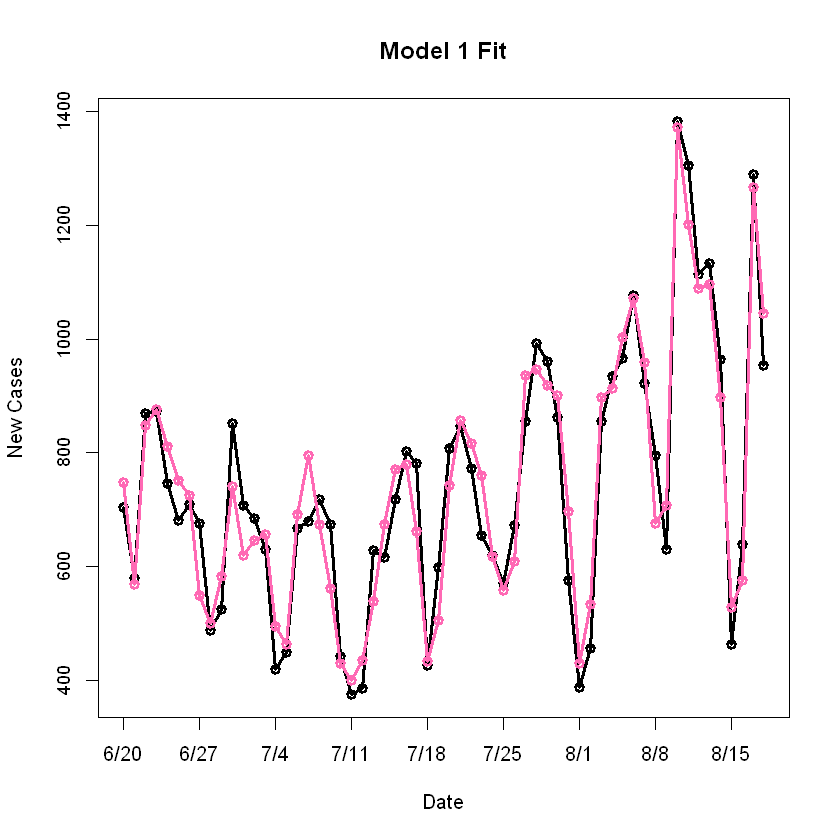

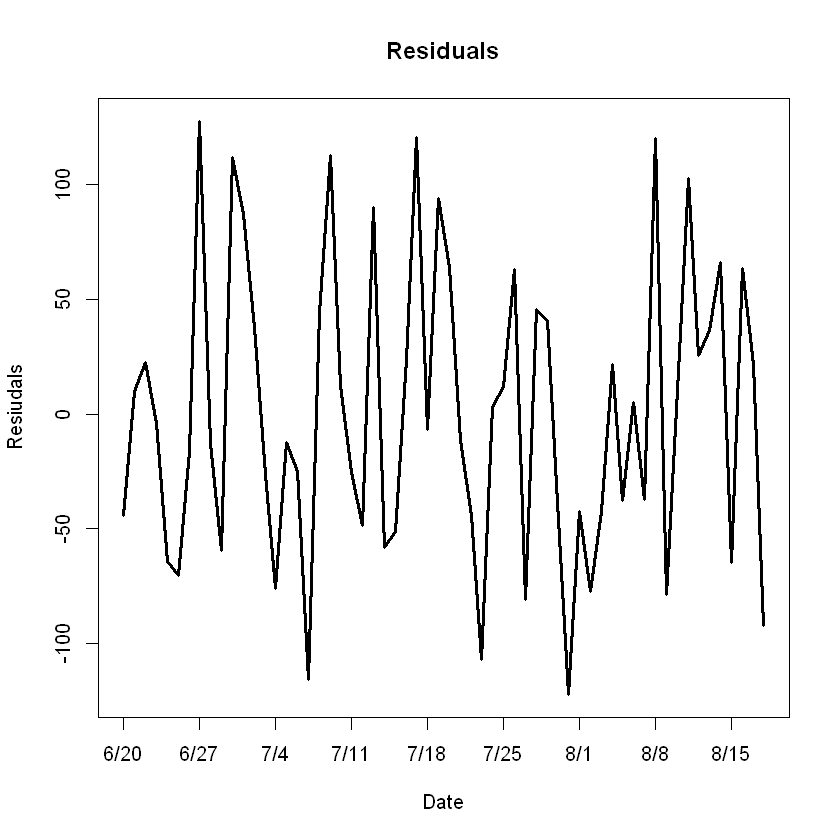

In [29]:
# Parametric Model

#plot data
plot.ts(df$New.Cases, type = "o", lwd = 2.5, 
        xaxt = "n", yaxt = "n", xlab = "Date", ylab = "New Cases", main = "Model 1 Fit")
axis(side = 1, at = seq(1,60, by = 7), labels = xLabel)
axis(side = 2, at = seq(400,1400, by = 200), labels = seq(400,1400, by = 200), cex.axis = 0.9)

# construct model per Equation 1. 
m1 <- lm(df$New.Cases ~ time + I(time^2) + 
           df$DoW*time + df$DoW*I(time^2) + df$MoY + 
           df$DoW*cos(2*pi*time*(1/12)) + df$DoW*sin(2*pi*time*(1/12)) 
         )

lines(time, m1$fitted.values, col = "hotpink", type = "o", lwd = 2.5)

#plot residuals: model (pink) - data (black)
plot.ts(m1$residuals, lwd = 2.5, 
        xaxt = "n", xlab = "Date", ylab = "Resiudals", main = "Residuals")
axis(side = 1, at = seq(1,60, by = 7), labels = xLabel)
#m1.spec <- mvspec(m1$residuals)

### 3.1.1   Model 1.1: Parametric Signal with SARMA(0,1)[14]

ACF,0.04,-0.16,0.04,0.06,-0.14,-0.21,-0.15,0.19,0.21,-0.16,...,-0.16,-0.03,-0.07,0.01,0.00,0.12,-0.01,0.17,0.05,-0.12
PACF,0.04,-0.17,0.06,0.03,-0.13,-0.19,-0.19,0.16,0.20,-0.13,...,-0.33,0.11,0.12,-0.09,0.03,-0.13,-0.13,-0.10,0.17,0.12


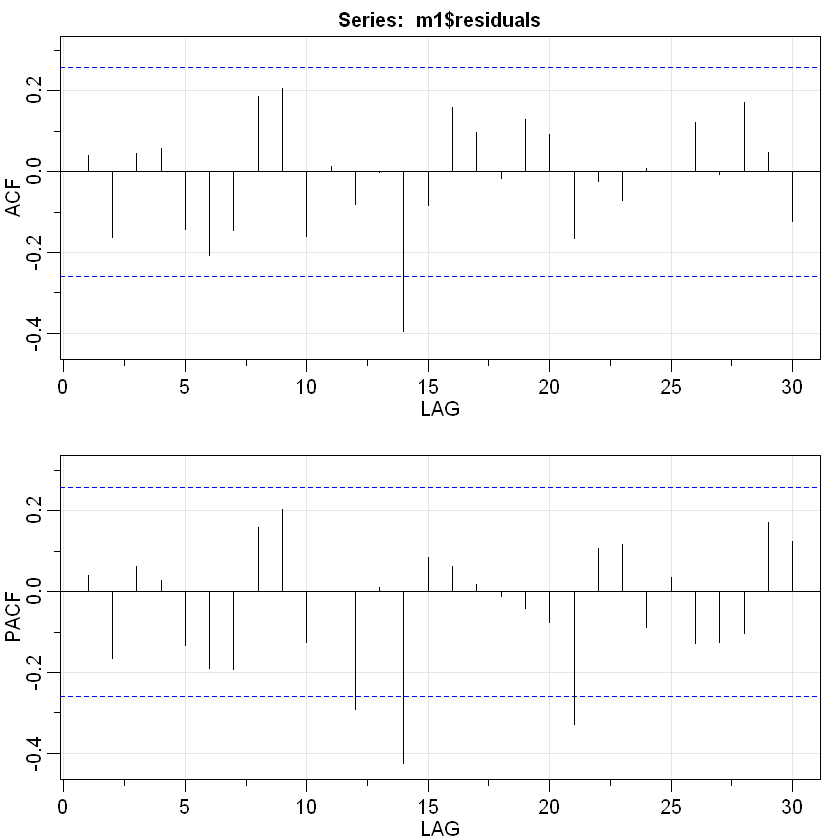

In [42]:
acf2(m1$residuals, max.lag = 30) #acf and pacf of m1 residuals

In [43]:
auto.arima(m1$residuals) 

Series: m1$residuals 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 4087:  log likelihood=-334.6
AIC=671.2   AICc=671.27   BIC=673.3

The ACF and PACF plots for the parametric model's residuals are shown in Figure 3. Lag 14 is the only lag with a significant ACF value (i.e. a lag with ACF/PACF value beyond the 95% CI for white noise). Lags with significant PACF values occur at lags 12, 14, and 21. The significant ACF/PACF values at weekly intervals indicate a potential SARMA(p,q)[7] fit. However, trial and error with maximum P=Q=3 had low  Ljung-Box statistic p-values for the SARMA(p,q)[7] residuals. Now, of lags 12, 14, and 21, lag 14 is the only lag with a PACF value substantially over the 95% CI for white noise. As such, we focus our noise models on accounting for the ACF/PACF value at lag 14. This leads to the proposal of SARMA(0,1)[14] (henceforth, Model 1.1). This model's theoretical ACF and PACF values are indicated by the blue circles in the left plots of Figure 3. Ljung-Box statistic p-values for the residuals of SARMA(0,1)[14] are shown by the blue circles in the right plot of Figure 3. P-values over 5% for all lags $h<=30$ indicate that it is plausible that our residuals came from the proposed SARMA(0,1)[14] process.

In [ ]:
m1.1 <- sarima(m1$residuals, p=0,d=0,q=0, P=0,D=0,Q=1,S=14)
m1.2 <- sarima(m1$residuals, p=0,d=0,q=0, P=1,D=0,Q=1,S=14)

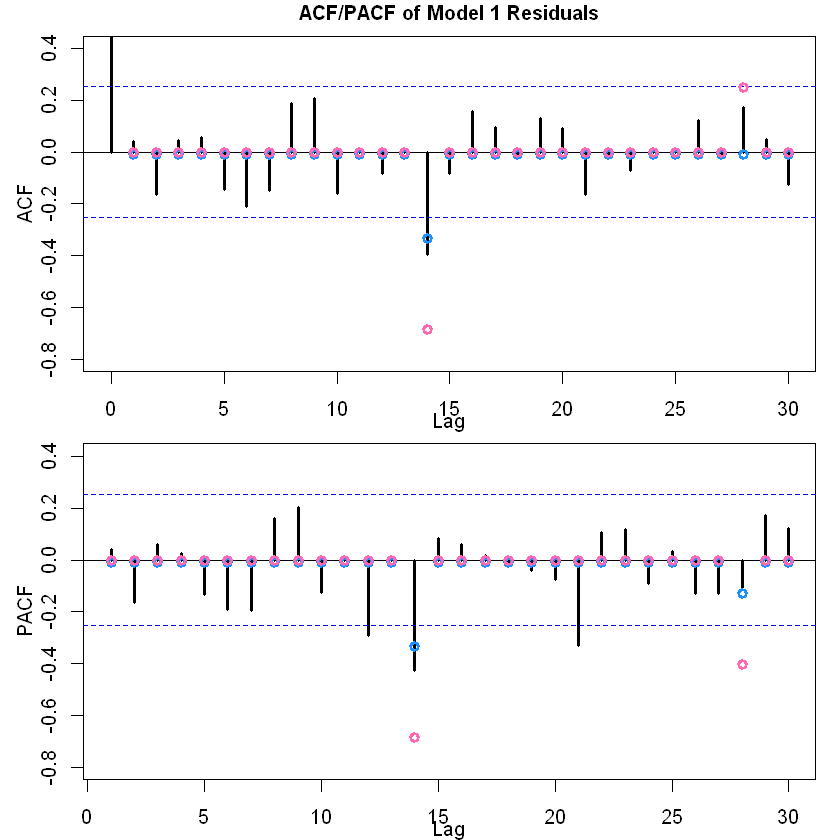

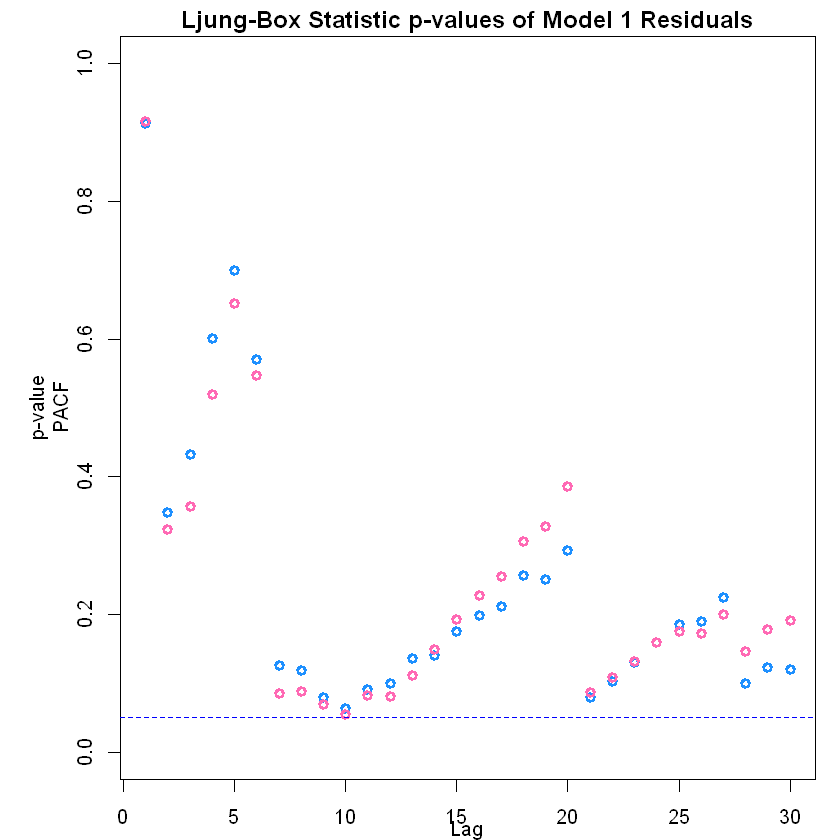

In [44]:
#Diagnose noise models for m1 (m1.1 and m1.2)

#plot multiple graphs in 1 frame
plot.new(); par(new = TRUE, fig=c(0,1,0.5,1), mai = c(0.4,0.7,0.3,0.2))

m1.1.theoretical_acf <- ARMAacf(ma = c(rep(0,13), m1.1$fit$coef[1]), lag.max = 30)
m1.2.theoretical_acf <- ARMAacf(ar = c(rep(0,13), m1.1$fit$coef[1]),
                                ma = c(rep(0,13), m1.1$fit$coef[2]), lag.max = 30)

acf(m1$residuals, lag.max = 30, ylim = c(-0.8,0.4), main = "", 
    ylab = "", xlab = "", lwd = 2.5)
points(0:30, m1.1.theoretical_acf - 0.01, col = "dodgerblue", lwd = 2.5)
points(0:30, m1.2.theoretical_acf, col = "hotpink", lwd = 2.5)

mtext("ACF", side = 2, line = 2); mtext("Lag", side = 1, line = 1.5)
mtext("ACF/PACF of Model 1 Residuals", side = 3, line = 0.5, font = 2)
par(new = TRUE, fig=c(0,1,0,0.5), mai = c(0.5,0.7,0.2,0.2))

#PACF ----------
m1.1.theoretical_pacf <- ARMAacf(ma = c(rep(0,13), m1.1$fit$coef[1]), lag.max = 30, pacf = TRUE)
m1.2.theoretical_pacf <- ARMAacf(ar = c(rep(0,13), m1.1$fit$coef[1]),
                                ma = c(rep(0,13), m1.1$fit$coef[2]), lag.max = 30, pacf = TRUE)

pacf(m1$residuals, ylim = c(-0.8,0.4),lag.max = 30, main = "", 
     ylab = "", xlab = "", lwd = 2.5)
points(1:30, m1.1.theoretical_pacf - 0.01, col = "dodgerblue", lwd = 2.5)
points(1:30, m1.2.theoretical_pacf, col = "hotpink", lwd = 2.5)

mtext("PACF", side = 2, line = 2); mtext("Lag", side = 1, line = 1.5)

# Ljung Box Test ----------
plot.new(); par(new = TRUE, fig=c(0,1,0,1), mai = c(0.5,1,0.3,0.2))

m1.1.LB_Pvalues <- LjungBoxTest(m1.1$fit$residuals,lag.max = 30)
m1.2.LB_Pvalues <- LjungBoxTest(m1.2$fit$residuals,lag.max = 30)

plot(c(1:30), m1.1.LB_Pvalues[61:90], col = "dodgerblue", type = "p", lwd = 2.5, 
     ylim = c(0,1), ylab = "p-value", xlab = "", main = "Ljung-Box Statistic p-values of Model 1 Residuals")
points(c(1:30), m1.2.LB_Pvalues[61:90], col = "hotpink", lwd = 2.5)
mtext("PACF", side = 2, line = 2); mtext("Lag", side = 1, line = 1.5)

# add 5% interval
abline(h = 0.05, col = "blue", lty = 2)

### 3.1.2   Model 1.2: Parametric Signal with SARMA(1,1)[14]

SARMA(1,1)[14] (henceforth, Model 1.2) is another plausible model since the PACF value at lag-14 is not flanked by similarly significant ACF/PACF values at subsequent lags. Pink circles on the left of Figure 3 indicate Model 1.2's theoretical ACF/PACF values. Similarly, pink circles on the right of Figure 3 indicate Ljung-Box statistic p-values for Model 1.2's residuals. Both models have similar Ljung-Box statistic p-values, however, the theoretical ACF/PACF values for the SARMA(0,1)[14] process more closely resemble the residual ACF/PACF. 


## 3.2   Model 2: Differencing

We also pursue stationary through differencing. Transforming the original time series of new cases of COVID-19 through lag-1 differencing removes the increasing trend. We can further remove the the weekly periodicity with lag-7 differencing. The combination of two successive differences (lag-1 and lag-7) yields a plaussibly stationary process. The process resulting from the two successive differences is shown in Figure 4. 

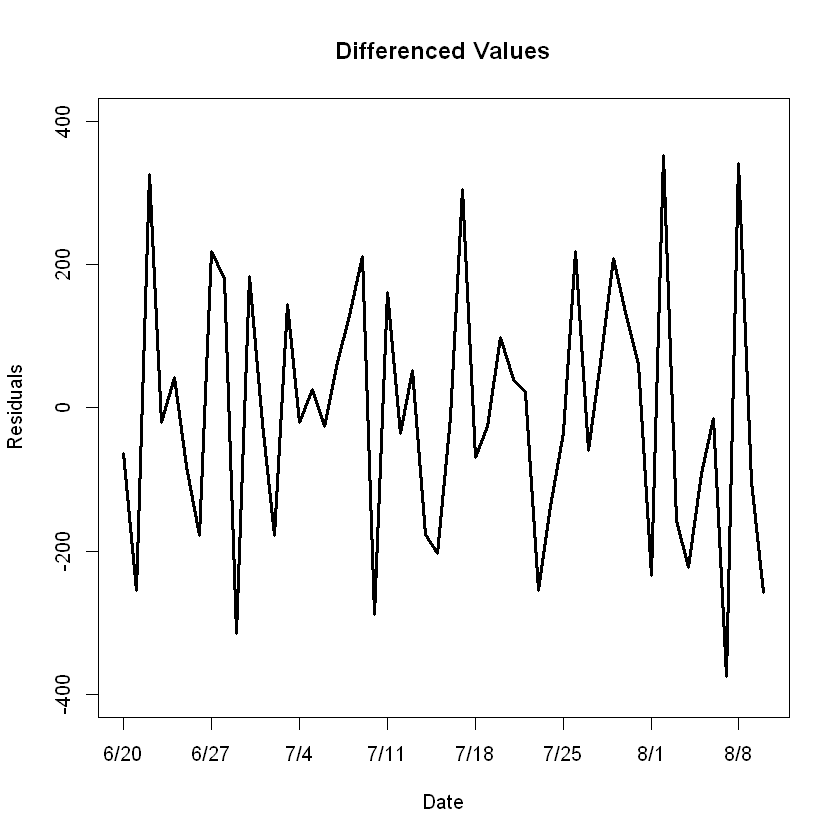

In [45]:
m2 <- diff(diff(df$New.Cases), lag = 7) #two successive differences

plot.ts(m2, lwd = 2.5, ylim = c(-400,400), 
        xaxt = "n", xlab = "Date", ylab = "Residuals", main = "Differenced Values")
axis(side = 1, at = seq(1,60, by = 7), labels = xLabel)

### 3.2.1   Model 2.1: Differencing with MA(1)

In [ ]:
m2.1 <- sarima(df$New.Cases, p=0,d=1,q=1, P=0,D=1,Q=0,S=7)
m2.2 <- sarima(df$New.Cases, p=0,d=1,q=1, P=1,D=1,Q=1,S=7)

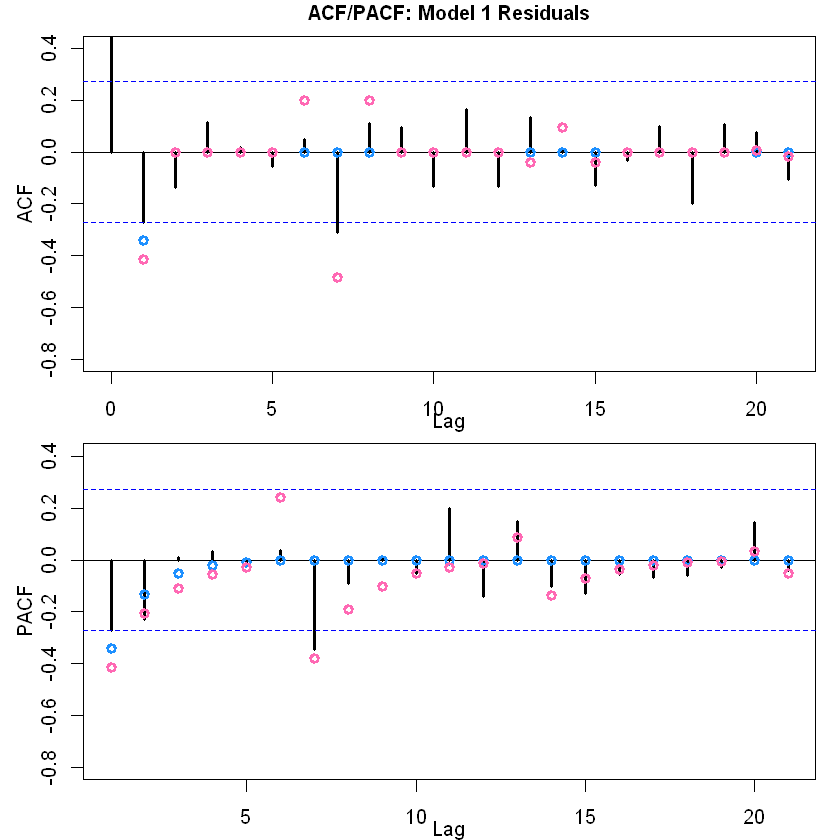

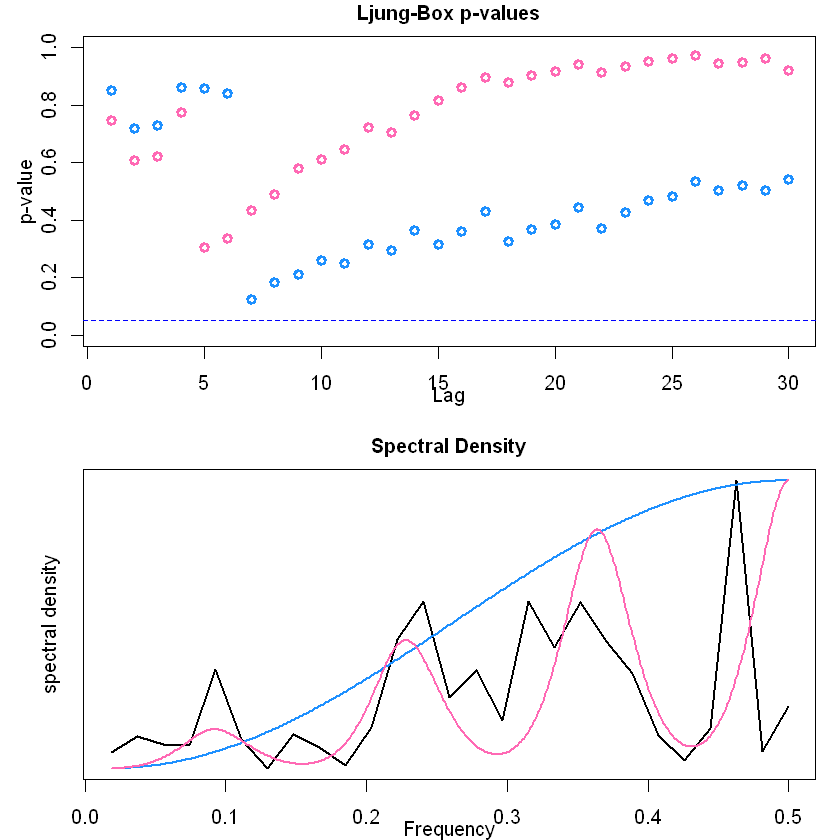

In [50]:
# Diagnose noise models for m2.1 and m2.2
plot.new(); par(new = TRUE, fig=c(0,1,0.5,1), mai = c(0.4,0.7,0.3,0.2))

m2.1.theoretical_acf <- ARMAacf(ma = c(m2.1$fit$coef[1]), lag = 30)
m2.2.theoretical_acf <- ARMAacf(ar = c(rep(0,6), m2.2$fit$coef[2]),
                                ma = c(m2.2$fit$coef[1], rep(0,5), m2.2$fit$coef[3],
                                       m2.2$fit$coef[1]*m2.2$fit$coef[3]), 
                                lag = 30)

acf(m2, lag.max = 21, ylim = c(-0.8,0.4), main = "", 
    ylab = "", xlab = "", lwd = 2.5)
points(0:30, m2.1.theoretical_acf, col = "dodgerblue", lwd = 2.5)
points(0:30, m2.2.theoretical_acf, col = "hotpink", lwd = 2.5)

mtext("ACF", side = 2, line = 2); mtext("Lag", side = 1, line = 1.5)
mtext("ACF/PACF: Model 1 Residuals", side = 3, line = 0.5, font = 2)

#PACF ----------
par(new = TRUE, fig=c(0,1,0,0.5), mai = c(0.5,0.7,0.2,0.2))
m2.1.theoretical_pacf <- ARMAacf(ma = c(m2.1$fit$coef[1]), pacf = TRUE, lag = 30)
m2.2.theoretical_pacf <- ARMAacf(ar = c(rep(0,6), m2.2$fit$coef[2]),
                                 ma = c(m2.2$fit$coef[1], rep(0,5), m2.2$fit$coef[3],
                                        m2.2$fit$coef[1]*m2.2$fit$coef[3]), 
                                 pacf = TRUE, lag = 30)

pacf(m2, ylim = c(-0.8,0.4),lag.max = 21, main = "", 
     ylab = "", xlab = "", lwd = 2.5)
points(1:30, m2.1.theoretical_pacf, col = "dodgerblue", lwd = 2.5)
points(1:30, m2.2.theoretical_pacf, col = "hotpink", lwd = 2.5)

mtext("PACF", side = 2, line = 2); mtext("Lag", side = 1, line = 1.5)

# Ljung Box Test ----------
plot.new(); par(new = TRUE, fig=c(0,1,0.53,1), mai = c(0.4,0.7,0.3,0.2))

m2.1.LB_Pvalues <- LjungBoxTest(m2.1$fit$residuals,lag.max = 30)
m2.2.LB_Pvalues <- LjungBoxTest(m2.2$fit$residuals,lag.max = 30)

plot(c(1:30), m2.1.LB_Pvalues[61:90], col = "dodgerblue", type = "p", lwd = 2.5, 
     ylim = c(0,1), ylab = "", xlab = "", main = "")
points(c(1:30), m2.2.LB_Pvalues[61:90], col = "hotpink", lwd = 2.5)

mtext("p-value", side = 2, line = 2); mtext("Lag", side = 1, line = 1.5)
mtext("Ljung-Box p-values", side = 3, line = 0.5, font = 2)

# add 5% interval
abline(h = 0.05, col = "blue", lty = 2)

# SPECTRAL DENSITY ----------
m2.spec <- mvspec(m2) #spectral density of m2 
#theoretical spectral density of differencing + MA(1)
m2.1.theoretical_spec <- arma.spec(ma = m2.1$fit$coef[1]) 
m2.2.theoretical_spec <- arma.spec(ma = c(m2.2$fit$coef[1],0,0,0,0,0,
                                   m2.2$fit$coef[3],m2.2$fit$coef[1]*m2.2$fit$coef[3]), 
                                   ar = c(0,0,0,0,0,0,m2.2$fit$coef[2]))

par(new = TRUE, fig=c(0,1,0,0.47), mai = c(0.5,0.7,0.2,0.2))
plot(m2.spec$freq, m2.spec$spec, type = "l", ylab = "", yaxt = "n", xlab = "",
     lwd = 2)
par(new = TRUE, fig=c(0,1,0,0.47), mai = c(0.5,0.7,0.2,0.2))
plot(m2.1.theoretical_spec$freq, m2.1.theoretical_spec$spec, 
     xaxt = "n", yaxt = "n", ylab = "", xlab = "", main = "", 
     type = "l", lwd = 2, col = "dodgerblue")
par(new = TRUE, fig=c(0,1,0,0.47), mai = c(0.5,0.7,0.2,0.2))
plot(m2.2.theoretical_spec$freq, m2.2.theoretical_spec$spec, 
     xaxt = "n", yaxt = "n", ylab = "", xlab = "", main = "", 
     type = "l", lwd = 2, col = "hotpink")

mtext("spectral density", side = 2, line = 1); mtext("Frequency", side = 1, line = 1.5)
mtext("Spectral Density", side = 3, line = 0.5, font = 2)

The ACF/PACF of the differenced series is shown in Figure 5. While still within the 95% CI for white noise, the ACF value at lag-1 is comparatively large making an MA(1) component plausible. The theoretical ACF/PACF for the fitted MA(1) process is shown as the blue marks in Figure 5. Interestingly, even though there is a significant ACF/PACF value at lag 7, the MA(1) process has significant Ljung-Box statistic p-values indicated by the blue marks in the top right plot of Figure 5. However, note that the spectral density for MA(1) does not align well with the spectral density of the differenced series. 

### 3.2.2   Model 2.2: Differencing with ARMA(0,1)x(1,1)[7]

Lag 7 has significant ACF and PACF values. As such, we propose that the SARMA(1,1)[7] component be added to the MA(1) model to get ARMA(0,1)x(1,1)[7] (henceforth, Model 2.2). Residuals for Model 2.2 have more significant Ljung-Box statistic p-values than residuals for Model 2.1 indicating potentially better fit. However, of most interest is the spectral density of Model 2.2. Unlike MA(1), The spectral density of ARMA(0,1)x(1,1)[7] resembles the observed spectral density. 

# 4 Model Comparison and Selection

In [ ]:
# Cross Validation

RMSE <- c(m1.1=0, m1.2=0, m2.1=0, m2.2=0)

for (i in c(30:50)) {
  m1.noise_train <- m1$residuals[1:i]
  m2.train <- df$New.Cases[1:i]
  
  test_set <- df$New.Cases[(i+1):(i+10)]
  
  m1.1.noiseForecast <- sarima.for(m1.noise_train, n.ahead=10, p=0,d=0,q=0, P=0,D=0,Q=1,S=14)$pred
  m1.2.noiseForecast <- sarima.for(m1.noise_train, n.ahead=10, p=0,d=0,q=0, P=1,D=0,Q=1,S=14)$pred
  
  m1.1.forecast <- m1.1.noiseForecast + m1$fitted.values[(i+1):(i+10)]
  m1.2.forecast <- m1.2.noiseForecast + m1$fitted.values[(i+1):(i+10)]
  
  m2.1.forecast <- sarima.for(m2.train, n.ahead=10, p=0,d=1,q=1, P=0,D=1,Q=0,S=7)$pred
  m2.2.forecast <- sarima.for(m2.train, n.ahead=10, p=0,d=1,q=1, P=1,D=1,Q=1,S=7)$pred
  
  RMSE[1] = RMSE[1] + sum((m1.1.forecast - test_set)^2)
  RMSE[2] = RMSE[2] + sum((m1.2.forecast - test_set)^2)
  RMSE[3] = RMSE[3] + sum((m2.1.forecast - test_set)^2)
  RMSE[4] = RMSE[4] + sum((m2.2.forecast - test_set)^2)
}

RMSE <- sqrt(RMSE/(21*10))

RMSE.revised <- c(m1.1=0)
df$time <- c(1:60)

for (i in c(30:50)) {
  m1.noise_train <- m1$residuals[1:i]
  m1.signal_train <- df[c(1:i), c(1:5)]
  m1.signal_predict_vars <- df[c((i+1):(i+10)), c(1,3,4,5)]
  test_set <- df$New.Cases[(i+1):(i+10)]
  m1.signal_train$time
  
  
  m1.model_i <- lm(m1.signal_train$New.Cases ~ m1.signal_train$time + I(m1.signal_train$time^2) + 
                     m1.signal_train$DoW*m1.signal_train$time + 
                     m1.signal_train$DoW*I(m1.signal_train$time^2) + 
                     m1.signal_train$MoY + 
                     m1.signal_train$DoW*cos(2*pi*m1.signal_train$time*(1/12)) + 
                     m1.signal_train$DoW*sin(2*pi*m1.signal_train$time*(1/12)),
                   data = m1.signal_train)
  new_data <- data.frame(time = 31, DoW = "Monday", MoY = "July")
  
  predict.lm(m1.model_i, newdata = new_data)  
    
    
  m1.1.noiseForecast <- sarima.for(m1.noise_train, n.ahead=10, p=0,d=0,q=0, P=0,D=0,Q=1,S=14)$pred
  
  m1.1.forecast <- m1.1.noiseForecast + m1$fitted.values[(i+1):(i+10)]

  RMSE.revised[1] = RMSE.revised[1] + sum((m1.1.forecast - test_set)^2)
}

RMSE.revised <- sqrt(RMSE.revised/(21*10))

In [54]:
# Information Criteria
m1.1$AIC; m1.1$AICc; m1.1$BIC
m1.2$AIC; m1.2$AICc; m1.2$BIC

m2.1$AIC; m2.1$AICc; m2.1$BIC
m2.2$AIC; m2.2$AICc; m2.2$BIC


[1] 11.09744

[1] 11.10095

[1] 11.20215

[1] 11.05412

[1] 11.06126

[1] 11.19374

[1] 11.79691

[1] 11.79814

[1] 11.8642

[1] 11.66443

[1] 11.67209

[1] 11.799

To assess the four models, time series cross validation was performed by iterating daily from 7/19/2020 to 8/8/2020 with the training set compromised of those dates before and on the iterated value and the testing set 10 days following the iterated value. This results in 21 overlapping testing windows, each consisting of 10 days of data, beginning with the testing window 7/19/2020-7/28/2020. Model forecasting performance is assessed through root-mean-square prediction error (RMSPE). Model fit with penalties for increasing penalty are assesed through 3 information criteria: AIC, AICc, and BIC. Information criteria and RMSPE are given in table 1.

\begin{table}[!h]
\centering
\caption{Assessing the Four Models}
\begin{tabular}{l | l l l l l }
\hline
Model & Description & AIC & AICc & BIC & RMSPE \\ \hline
1.1 & Parametric Model + SARMA(0,1)[14] & 11.097 & 11.101 & 11.202 & 58.311 \\
1.2 & Parametric Model + SARMA(1,1)[14] & 11.054 & 11.061 & 11.194 & 60.807 \\
2.1 & Differencing + MA(1) & 11.797 & 11.798 & 11.864 & 253.551 \\
2.2 & Differencing + ARMA(0,1)x(1,1)[7] & 11.664 & 11.672 & 11.799 & 214.195 \\ \hline
\end{tabular}
\end{table}

The set of Models 1.1 and 1.2 have substantially smaller RMSPE than the set of Models 2.1 and 2.2. Model 1.2 has smaller information criteria than Model 1.1, however because the difference in information criteria is relatively small (<0.1) and because we are most interested in forecasting ability, Model 1.1 -- the parametric model with SARMA(0,1)[14] -- is selected to forecast the next 10 days of new COVID-19 cases. 

# 5   Results 
## 5.1   Mathematical Model
Combining the noise and signal components of Model 1.2 yields Equation 2. Here, $W_t$ is white noise with variance $\sigma^2_W$, and $X_t$ is the stationary process defined by SARMA(0,1)[14] that results from the residuals of the parametric model (Model 1). 

\begin{align}
\text{Cases}_t &= \beta_0 + \beta_1t +\beta_2t^2 +
\sum_{j=1}^6 \left[  (\beta_{3j}+\beta_{3j+1} t+\beta_{3j+2} t^2) I_{\text{weekday}_{jt}} \right] +
\beta_{21} \cos \left(\frac{2\pi t}{12} \right) + 
\beta_{22} \sin \left(\frac{2\pi t}{12} \right) \notag \\
&+ \sum_{j=1}^6 \left[ \left(\beta_{2j+21} \cos \left(\frac{2\pi t}{12} \right) + \beta_{2j+22} \sin \left(\frac{2\pi t}{12} \right)\right) I_{\text{weekday}_{jt}} \right] + \beta_{35} I_{\text{June}_t} + \beta_{36} I_{\text{July}_t} + X_t. \notag \\
\text{where,} \notag \\
&X_t = W_t + \Theta W_{t-14}.
\end{align}

Binary indicators are denoted by the $I$ operator, where $I_{\text{weekday}_{jt}}$ is 1 if day $t$ is the $j$th day of the week (and 0 otherwise), and $I_{\text{June}_t}/I_{\text{July}_t}$ are 1 if day $t$ is in June or July respectively (and 0 otherwise). $\beta_i$ and $\Theta$ are constants that are estimated in the following subsection. 

## 5.2   Parameters
The values for the constants $\beta_i$ and $\Theta$ in Equation 2 are tabulated in Table 2 of Appendix 1. As expected, day of the week interaction parameters yield similar values on the weekdays all of which are larger than the weekend interaction parameter values. 


## 5.3   Forecast
We forecast the next 10 days of new COVID-19 cases from 8/19/2020 to 8/28/2020. The predicted values follow the overall quadratic trend seen in the historical data. Moreover, we see the repeated trend of troph weekend values as the forecasted values troph on the weekends: 8/22/2020 and 8/23/2020 (Saturday and Sunday, respectively). We include the uncertainty interval of the SARMA(0,1)[14] model to one and two standard errors in dark and light grey respectively. These intervals represent the uncertainty of the noise component of our model, but omit the uncertainty of the parametric signal component of the model. We predict a peak in new cases on 8/24/2020, and even at the lower bound of the 98% prediction interval for 8/24/2020, new cases of COVID-19 in Gotham City reach a historical high. 


In [ ]:
# m1.1 forecast

m1.1.predict <- function(time = 61, day = "Wednesday", month = "August"){
  C <- m1$coefficients
  
  constant_part <- C[1] + C[2]*time + C[3]*(time^2) + 
                   C[12]*cos(2*pi*time*(1/12)) + C[13]*sin(2*pi*time*(1/12))
  
  alphabetical_day_order <- c("Monday", "Saturday", "Sunday", "Thursday", "Tuesday", "Wednesday")
  
  if(day == "Friday"){
    day_index <- 0
    weekly_part <- 0
  } else {
    day_index <- which(alphabetical_day_order == day) - 1
    weekly_part <- C[4+day_index] + C[14+day_index]*time + C[20 + day_index]*(time^2) + 
                   C[26+day_index]*cos(2*pi*time*(1/12)) + C[32+day_index]*sin(2*pi*time*(1/12))
  }
  
  if(month == "June"){
    monthly_part <- C[11]
  } else if(month == "July"){
    monthly_part <- C[10]
  } else{
    monthly_part <- 0
  }
  
  signal_predict <- constant_part + weekly_part + monthly_part
  
  noise_predict <- sarima.for(m1$residuals, n.ahead=10, p=0,d=0,q=0, P=0,D=0,Q=1,S=14)$pred
  
  return(signal_predict + noise_predict[time-60])
}

m1.1.p1 <- m1.1.predict(time = 61, day = "Wednesday")
m1.1.p2 <- m1.1.predict(time = 62, day = "Thursday")
m1.1.p3 <- m1.1.predict(time = 63, day = "Friday")
m1.1.p4 <- m1.1.predict(time = 64, day = "Saturday")
m1.1.p5 <- m1.1.predict(time = 65, day = "Sunday")
m1.1.p6 <- m1.1.predict(time = 66, day = "Monday")
m1.1.p7 <- m1.1.predict(time = 67, day = "Tuesday")
m1.1.p8 <- m1.1.predict(time = 68, day = "Wednesday")
m1.1.p9 <- m1.1.predict(time = 69, day = "Thursday")
m1.1.p10 <- m1.1.predict(time = 70, day = "Friday")

m1.1.predictions <- c(m1.1.p1, m1.1.p2, m1.1.p3, m1.1.p4, m1.1.p5, 
                      m1.1.p6, m1.1.p7, m1.1.p8, m1.1.p9, m1.1.p10)
m1.1.noiseForecast <- sarima.for(m1$residuals, n.ahead=10, p=0,d=0,q=0, P=0,D=0,Q=1,S=14)

#shade error intervals
m1.1.noiseForecast
shade.xs <- c(c(61:70), c(70:61))
shade.ys_oneSE <- c(m1.1.predictions + m1.1.noiseForecast$se, 
                    m1.1.predictions[10:1] - m1.1.noiseForecast$se)
shade.ys_twoSE <- c(m1.1.predictions + 2*m1.1.noiseForecast$se, 
                    m1.1.predictions[10:1] - 2*m1.1.noiseForecast$se)

plot.ts(df$New.Cases, type = "o", lwd = 2.5, xlim = c(1,70), ylim = c(0, 1800),
        xaxt = "n", xlab = "Date", ylab = "New Cases", main = "New Cases of COVID-19")

shade1 <- rgb(219, 219, 219, max = 255) #lighter grey for two SE
shade2 <- rgb(235, 235, 235, max = 255) #darker grey for one SE
shade3 <- rgb(192, 192, 192, max = 255) #interval outline color

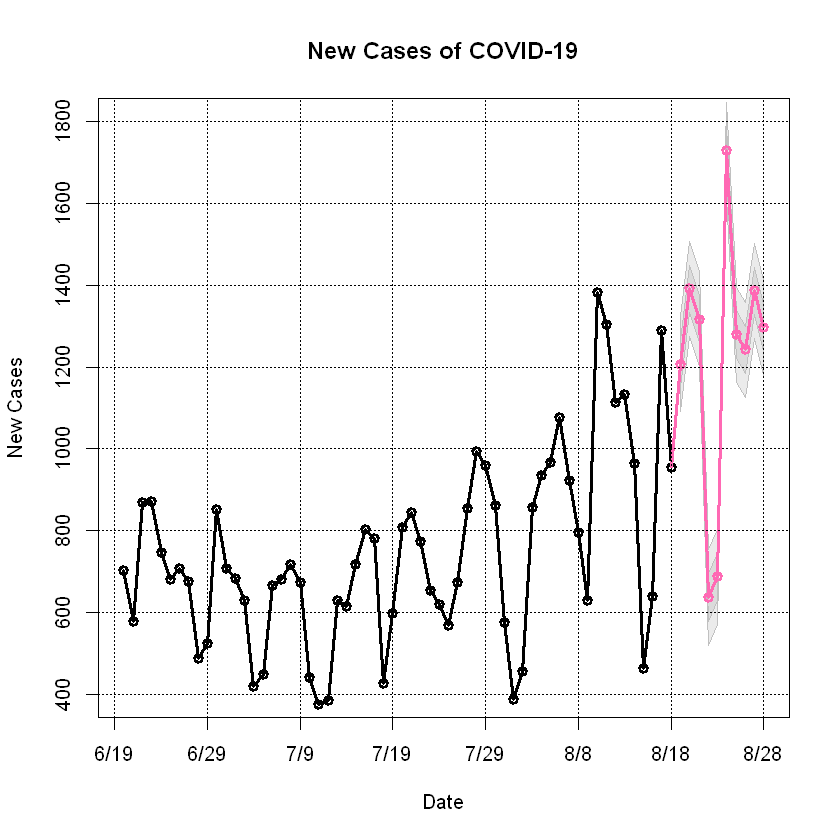

In [52]:
#shadding error
plot.ts(df$New.Cases, type = "o", lwd = 2.5, xlim = c(1,70), ylim = c(400, 1800),
        xaxt = "n", xlab = "Date", ylab = "New Cases", main = "New Cases of COVID-19")

polygon(shade.xs, shade.ys_twoSE, col = shade2, border = shade3)
polygon(shade.xs, shade.ys_oneSE, col = shade1, border = shade3)

lines(c(61:70), m1.1.predictions, type = "o", lwd = 2.5, col = "hotpink")
lines(c(60,61), c(df$New.Cases[60], m1.1.predictions[1]), lwd = 2.5, col = "hotpink")

xLabel <- c("6/19", "6/29", "7/9", "7/19", "7/29", "8/8", "8/18", "8/28") 

axis(side = 1, at = seq(0,70, by = 10), labels = xLabel)
grid(col = "black")